In [1]:
import warnings

import pooch

# don't need to show warning about setting up optimizer
warnings.filterwarnings(
    "ignore",
    message="You will need to call setup",
    category=UserWarning,
)

# don't have pooch output messages about downloading or untarring
logger = pooch.get_logger()
logger.setLevel("WARNING")

:::{admonition} Download
:class: important

Download this notebook: **{nb-download}`ps_examples.ipynb`**!

:::

(ps-examples)=
# Example Portilla-Simoncelli metamers from different texture classes

This notebook shows example metamers from several different classes of texture images. If you download the notebook, you can change the `fig_name` variable in each section to load further examples.

:::{admonition} Reproducing the metamers in this notebook
:class: warning dropdown

Due to pytorch's limitations, we [cannot guarantee perfect reproducibility](reproduce).
However, we've found the setup shown in this notebook works reliably across different images and produce good metamers efficiently.

If you use follow these basic steps and **are not** able to successfully synthesize a good `PortillaSimoncelli` <!-- skip-lint --> model metamer, please post on our [discussion board](https://github.com/plenoptic-org/plenoptic/discussions/) and we'll try to help!

See [](ps-optimization) for more information about the specific decisions taken around optimization, including what "good" means.

:::

In [2]:
import matplotlib.pyplot as plt
import torch

import plenoptic as po

%load_ext autoreload
%autoreload 2

# We need to download some additional images for this notebook.
IMG_PATH = po.data.fetch_data("portilla_simoncelli_images.tar.gz")
CACHE_DIR = po.data.fetch_data("ps_regression.tar.gz")
# use GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72

# set seed for reproducibility
po.tools.set_seed(1)

:::{admonition} This notebook retrieves cached synthesis results
:class: warning dropdown
This notebook contains many metamers and, while any one synthesis operation does not take too long, all of them combined result in a lengthy notebook. Therefore, instead of performing synthesis in this notebook, we have cached the result of most of these syntheses online and only download them for investigation.

Additionally, while you can normally call {func}`~plenoptic.synthesize.metamer.Metamer.synthesize` again to pick up where we left out, the cached version of the results shown here discarded the optimizer's state dict (to reduce the size on disk). Thus, calling `met.synthesize(100)` with one of our cached and loaded metamer objects **will not** give the same result as calling `met.synthesize(200)` with a new metamer object initialized as shown in this notebook.

:::

## Hand-drawn / computer-generated textures

(See figure 12 of {cite:alp}`Portilla2000-param-textur`.)

The following cell can be used to reproduce texture synthesis on the hand-drawn / computer-generated texture examples in the original paper, showing that the model can handle these simpler images as well.

Examples

- (12a) solid black squares
- (12b) tilted gray columns
- (12c) curvy lines
- (12d) dashes
- (12e) solid black circles
- (12f) pluses

In [3]:
fig_name = "fig12c"
img = po.tools.load_images(IMG_PATH / f"{fig_name}.jpg")
img = img.to(DEVICE).to(torch.float64)

# fig12b is a sawtooth grating, with 4 scales the steerable pyramid's residual lowpass
# is uniform and thus correlation between it and the coarsest scale is all NaNs (i.e.,
# the last scale of auto_correlation_reconstructed is all NaNs)
n_scales = 3 if fig_name == "fig12b" else 4
model = po.simul.PortillaSimoncelli(img.shape[-2:], n_scales=n_scales).to(DEVICE)
loss = po.tools.optim.portilla_simoncelli_loss_factory(model, img)
# to avoid running so many syntheses in this notebook, we load a cached version. see the
# following admonition for how to run this yourself
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met.load(CACHE_DIR / f"ps_basic_synthesis_{fig_name}.pt", map_location=DEVICE)

:::{admonition} How to run this synthesis manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_basic_synthesis -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
n_iters = 150 if fig_name in ["fig12a", "fig12b"] else 100
met.synthesize(max_iter=n_iters)
```
:::

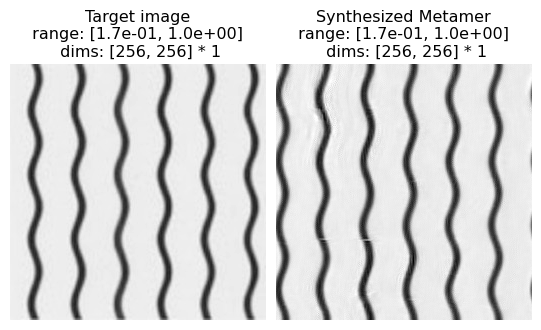

In [4]:
po.imshow(
    [met.image, met.metamer],
    title=["Target image", "Synthesized Metamer"],
    vrange="auto1",
);

## Counterexample to the Julesz Conjecture

The Julesz conjecture, originally from {cite:alp}`Julesz1962-visual-patter-discr`, states that "humans cannot distinguish between textures with identical second-order statistics" (second-order statistics include the cross- and auto-correlations included in the Portilla-Simoncelli model, see Julesz paper for details). Following up on this initial paper, [Julesz et al, 1978](https://link.springer.com/article/10.1007/BF00336998) and then [Yellot, 1993](https://opg.optica.org/josaa/abstract.cfm?uri=josaa-10-5-777) created images that served as counter-examples for this conjecture: pairs of images that had identical second-order statistics (they differed in their third- and higher-order statistics) but were readily distinguishable by humans. In figure 13 of {cite:alp}`Portilla2000-param-textur`, the authors show that the model is able to synthesize novel images based on these counterexamples that are *also* distinguishable by humans, so the model does not confuse them either.

:::{admonition} What's a third-order statistic?
:class: dropdown hint

{attribution="[Wikipedia: Higher-order statistics](https://en.wikipedia.org/wiki/Higher-order_statistics)"}
> In statistics, the term higher-order statistics (HOS) refers to functions which use the third or higher power of a sample, as opposed to more conventional techniques of lower-order statistics, which use constant, linear, and quadratic terms (zeroth, first, and second powers). The third and higher moments, as used in the skewness and kurtosis, are examples of HOS, whereas the first and second moments, as used in the arithmetic mean (first), and variance (second) are examples of low-order statistics.

:::

(See figure 13 of {cite:alp}`Portilla2000-param-textur`.)

Excerpt from paper: _"Figure 13 shows two pairs of counterexamples that have been used to refute the Julesz conjecture. \[13a and 13b were \] originally created by Julesz et al. (1978): they have identical third-order pixel statistics, but are easily discriminated by human observers. Our model succeeds, in that it can reproduce the visual appearance of either of these textures. In particular, we have seen that the strongest statistical difference arises in the magnitude correlation statistics. The rightmost pair were constructed by Yellott (1993), to have identical sample autocorrelation. Again, our model does not confuse these, and can reproduce the visual appearance of either one."_

Thus, by being able to distinguish these pairs of images, this model is able to reproduce an important result from the literature of human texture discrimination.

In [5]:
# Run on fig13a, fig13b, fig13c, fig13d to replicate examples in paper
fig_name = "fig13a"
img = po.tools.load_images(IMG_PATH / f"{fig_name}.jpg")
img = img.to(DEVICE).to(torch.float64)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
loss = po.tools.optim.portilla_simoncelli_loss_factory(model, img)
# to avoid running so many syntheses in this notebook, we load a cached version. see the
# following admonition for how to run this yourself
met_left = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met_left.load(CACHE_DIR / f"ps_basic_synthesis_{fig_name}.pt", map_location=DEVICE)

:::{admonition} How to run this synthesis manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_basic_synthesis[met_left:met] -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met_left.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
n_iters = 150 if fig_name in ["fig12a", "fig12b"] else 100
met_left.synthesize(max_iter=n_iters)
```
:::

In [6]:
# Run on fig13a, fig13b, fig13c, fig13d to replicate examples in paper
fig_name = "fig13b"
img = po.tools.load_images(IMG_PATH / f"{fig_name}.jpg")
img = img.to(DEVICE).to(torch.float64)

# Reuse the model and loss from above, only the loss is different
met_right = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met_right.load(CACHE_DIR / f"ps_basic_synthesis_{fig_name}.pt", map_location=DEVICE)

:::{admonition} How to run this synthesis manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_basic_synthesis[met_right:met] -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met_right.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
n_iters = 150 if fig_name in ["fig12a", "fig12b"] else 100
met_right.synthesize(max_iter=n_iters)
```
:::

And note that the two synthesized images (right column) are as distinguishable from each other as the two hand-crafted counterexamples (left column):

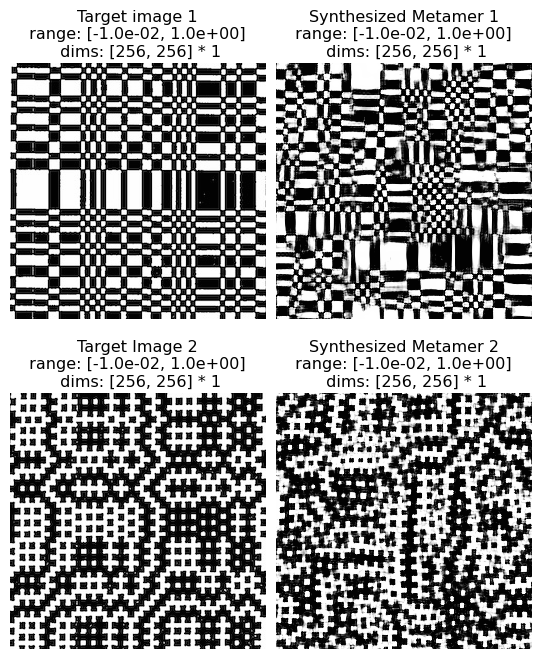

In [7]:
po.imshow(
    [
        met_left.image,
        met_left.metamer,
        met_right.image,
        met_right.metamer,
    ],
    title=[
        "Target image 1",
        "Synthesized Metamer 1",
        "Target Image 2",
        "Synthesized Metamer 2",
    ],
    vrange="auto1",
    col_wrap=2,
);

## Pseudo-periodic Textures

(See figure 14 of {cite:alp}`Portilla2000-param-textur`.)

Excerpt from paper: _"Figure 14 shows synthesis results photographic textures that are pseudo-periodic, such as a brick wall and various types of woven fabric"_

In [8]:
# Run on fig14a, fig14b, fig14c, fig14d, fig14e to replicate examples in paper
fig_name = "fig14a"
img = po.tools.load_images(IMG_PATH / f"{fig_name}.jpg")
img = img.to(DEVICE).to(torch.float64)

# We reuse the model and loss definition from the first section; the only difference
# is the image.
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met.load(CACHE_DIR / f"ps_basic_synthesis_{fig_name}.pt", map_location=DEVICE)

:::{admonition} How to run this synthesis manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_basic_synthesis -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
n_iters = 150 if fig_name in ["fig12a", "fig12b"] else 100
met.synthesize(max_iter=n_iters)
```
:::

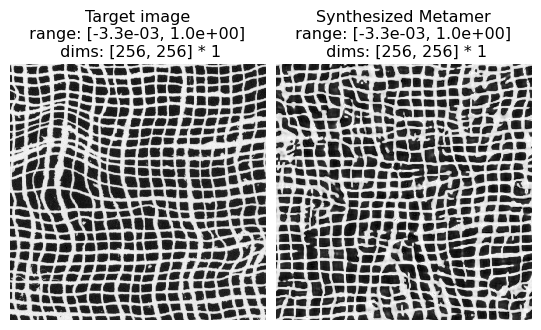

In [9]:
po.imshow(
    [met.image, met.metamer],
    title=["Target image", "Synthesized Metamer"],
    vrange="auto1",
);

## Aperiodic Textures

(See figure 15 of {cite:alp}`Portilla2000-param-textur`.)

Excerpt from paper: _"Figure 15 shows synthesis results for a set of photographic textures that are aperiodic, such as the animal fur or wood grain"_

In [10]:
# Run on fig15a, fig15b, fig15c, fig15d to replicate examples in paper
fig_name = "fig15a"
img = po.tools.load_images(IMG_PATH / f"{fig_name}.jpg")
img = img.to(DEVICE).to(torch.float64)

# We reuse the model and loss definition from the first section; the only difference
# is the image.
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met.load(CACHE_DIR / f"ps_basic_synthesis_{fig_name}.pt", map_location=DEVICE)

:::{admonition} How to run this synthesis manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_basic_synthesis -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
n_iters = 150 if fig_name in ["fig12a", "fig12b"] else 100
met.synthesize(max_iter=n_iters)
```
:::

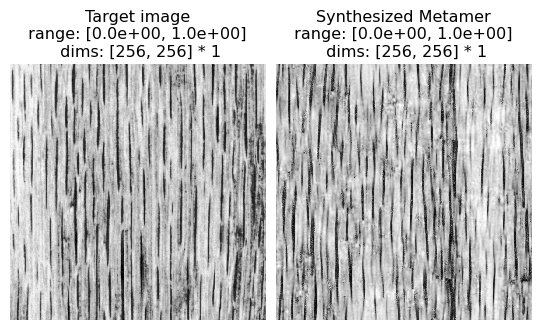

In [11]:
po.imshow(
    [met.image, met.metamer],
    title=["Target image", "Synthesized Metamer"],
    vrange="auto1",
);

## Complex Structured Photographic Textures

(See figure 16 of {cite:alp}`Portilla2000-param-textur`.)

Excerpt from paper: _"Figure 16 shows several examples of textures with complex structures. Although the synthesis quality is not as good as in previous examples, we find the ability of our model to capture salient visual features of these textures quite remarkable. Especially notable are those examples in all three figures for which shading produces a strong impression of three-dimensionality."_

In [12]:
# Run on fig16a, fig16b, fig16c, fig16d, fig16e to replicate examples in paper
fig_name = "fig16e"
img = po.tools.load_images(IMG_PATH / f"{fig_name}.jpg")
img = img.to(DEVICE).to(torch.float64)

# We reuse the model and loss definition from the first section; the only difference
# is the image.
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met.load(CACHE_DIR / f"ps_basic_synthesis_{fig_name}.pt", map_location=DEVICE)

:::{admonition} How to run this synthesis manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_basic_synthesis -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
n_iters = 150 if fig_name in ["fig12a", "fig12b"] else 100
met.synthesize(max_iter=n_iters)
```
:::

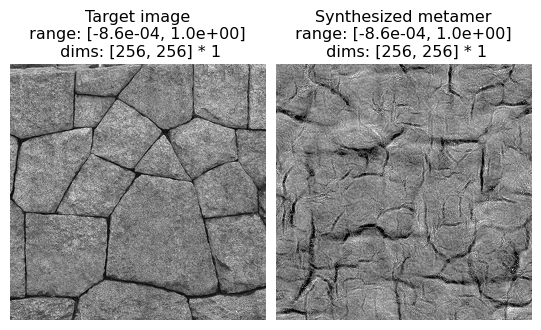

In [13]:
po.imshow(
    [met.image, met.metamer],
    title=["Target image", "Synthesized metamer"],
    vrange="auto1",
);

## Further reading

To learn more:
- about the different components of the model's representation, read the [](ps-model-stats) notebook.
- about the optimization choices taken above, read the [](ps-optimization) notebook.